In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time

# sets the default float-type
tf.keras.backend.set_floatx('float32')

class AxialBar1D:

  def __init__(self, xmin, xmax, q, N=1000, num_hidden_layers=1, num_neurons_per_layer=20, activation='tanh', actual_solution=None, epochs=5000):

    self.N = N
    self.epochs = epochs
    self.xmin = xmin
    self.xmax = xmax
    self.model = self.initialize_NN(num_hidden_layers, num_neurons_per_layer, activation)
    self.X = self.get_data()
    self.q = q
    self.learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,10000],[1e-2,1e-4,5e-5])
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    self.actual_solution = actual_solution
  
  def get_data(self):

    X = tf.random.uniform((self.N, 1), minval=self.xmin, maxval=self.xmax)
    X = tf.expand_dims(tf.sort(tf.squeeze(X)), axis=-1)
    return X
  
  def initialize_NN(self, num_hidden_layers, num_neurons_per_layer, activation):
    model = tf.keras.Sequential()
    # Add input layer
    model.add(tf.keras.Input(1))
    # Add the hidden layers
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation, kernel_initializer='glorot_normal'))
    # Add output layer
    model.add(tf.keras.layers.Dense(1))
    return model
  
  def psi(self, dudx):
    return (1+dudx)**1.5 - 1.5*dudx - 1
  
  def trapz(self, potential_energy, u):

    h = (self.xmax - self.xmin)/self.N
    integrand = potential_energy - self.q(self.X)*u
    integrand1 = integrand[1:]
    integrand0 = integrand[:-1]
    integral = (h/2)*tf.reduce_sum(integrand1 + integrand0)
    return integral

  def get_loss(self):

    with tf.GradientTape(persistent=True) as tape:
      x = self.X
      x_b1 = tf.ones((1, 1), dtype=tf.float32)*self.xmin
      x_b2 = tf.ones((1,1), dtype=tf.float32)*self.xmax
      tape.watch(x)
      tape.watch(x_b2)
      tape.watch(x_b1)

      # Find u (output of the model)
      u = self.model(x)
      dudx = tape.gradient(u, x)
      tape.watch(dudx)
      psi_of_x = self.psi(dudx)
      psi_grad = tape.gradient(psi_of_x, dudx)
      # Perform trapeoidal integration
      # integrand = psi_of_x - self.q*u
      # potential_energy = (self.xmax-self.xmin)*integrand
      # integral = self.trapz(psi_of_x, u)
      strong_form = tape.gradient(psi_grad, x)
      # Get the boundary loss for the fixed end 
      u_b1 = self.model(x_b1)
      # get the boundary loss for the natural boundary condition
      u_b2 = self.model(x_b2)
      dudx_b2 = tape.gradient(u_b2, x_b2)
    
    loss = tf.reduce_mean(tf.square(strong_form + x)) + tf.square(dudx_b2) + tf.square(u_b1)
    return loss
  
  def get_gradients(self):
    with tf.GradientTape(persistent=True) as tape:
      # This tape is for derivatives with
      # respect to trainable variables
      tape.watch(self.model.trainable_variables)
      loss = self.get_loss()

    g = tape.gradient(loss, self.model.trainable_variables)
    del tape
    return loss, g
  
  @tf.function
  def train_step(self):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = self.get_gradients()
    # Perform gradient descent step
    self.optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
    return loss
  
  def train(self):
    epochs = self.epochs
    hist = []

    # Start timer
    t0 = time()

    for i in range(epochs+1):
        
        loss = self.train_step()
        # Append current loss to hist
        hist.append(loss.numpy())
        # Output current loss after 50 iterates
        if i%50 == 0:
            print(f'It {i}: loss = {loss[0][0].numpy()}')
    # Print computation time
    print('\nComputation time: {} seconds'.format(time()-t0))

    # Get the mean_absolute error
    predictions = self.predict(self.X)
    if self.actual_solution != None:
      mae = tf.reduce_mean(tf.abs(predictions-self.actual_solution(self.X)))
      mse = tf.reduce_mean(tf.square(predictions-self.actual_solution(self.X)))
      mape = tf.reduce_mean(tf.abs(predictions-self.actual_solution(self.X))/self.actual_solution(self.X))
    else:
      mae = None
      mse = None
      mape = None
    return {'training_history': hist, 'training_time':time()-t0, 'mae': mae, 'mse':mse, 'mape':mape}
  
  def plot_results(self):
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(self.X)
      predicted_solution = self.model(self.X)
      predicted_slope = tape.gradient(predicted_solution, self.X)
      plt.figure(figsize=(10, 10))
      plt.plot(self.X, predicted_solution, label='predicted', color='cyan', linewidth=7 )
      if self.actual_solution != None:
        actual_solution = self.actual_solution(self.X)
        actual_slope = tape.gradient(actual_solution, self.X)
        plt.plot(self.X, actual_solution, label='actual', linestyle='dashed', color='red', linewidth=7)
      plt.xlabel("X")
      plt.ylabel("u(X)")
      plt.title("Axial Loading Prediction")
      plt.legend()
      # Plot the slope
      plt.figure(figsize=(10, 10))
      if self.actual_solution != None:
        plt.plot(self.X, actual_slope, label='actual', color='red', linewidth=7)
      plt.plot(self.X, predicted_slope, linewidth=7, label='predicted', color='lightgreen', linestyle='dashed')
      plt.xlabel("X")
      plt.ylabel("du(X)/dx")
      plt.title("Axial Loading Prediction Slope")
      plt.legend()
      plt.show()
    
  def predict(self, X):
    return self.model.predict(X)


### Experiment 1

* N = 1000
* epochs = 10000
* xmin = -1
* xmax = 1
* number of hidden layers = 1
* number of neurons per layer = 10

It 0: loss = 0.6871580481529236
It 50: loss = 0.14898259937763214
It 100: loss = 0.03582623228430748
It 150: loss = 0.02687409147620201
It 200: loss = 0.01999501697719097
It 250: loss = 0.014526012353599072
It 300: loss = 0.011136172339320183
It 350: loss = 0.009350498206913471
It 400: loss = 0.008232975378632545
It 450: loss = 0.00737413065508008
It 500: loss = 0.006639265455305576
It 550: loss = 0.005943730007857084
It 600: loss = 0.005161769688129425
It 650: loss = 0.0040621510706841946
It 700: loss = 0.002383613958954811
It 750: loss = 0.0006605401285924017
It 800: loss = 0.00018470812938176095
It 850: loss = 0.00017059294623322785
It 900: loss = 0.0001684806338744238
It 950: loss = 0.00016729097114875913
It 1000: loss = 0.00016454883734695613
It 1050: loss = 0.00016247841995209455
It 1100: loss = 0.00017616551485843956
It 1150: loss = 0.0001586599537404254
It 1200: loss = 0.00015659522614441812
It 1250: loss = 0.00015459292626474053
It 1300: loss = 0.00016343379684258252
It 1350: 

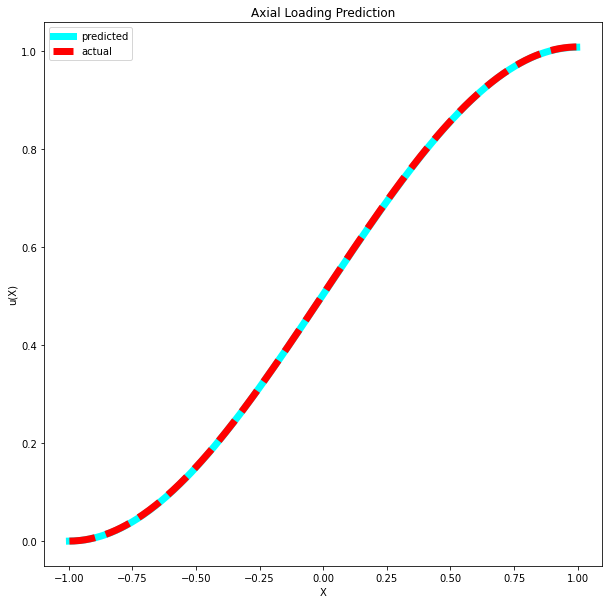

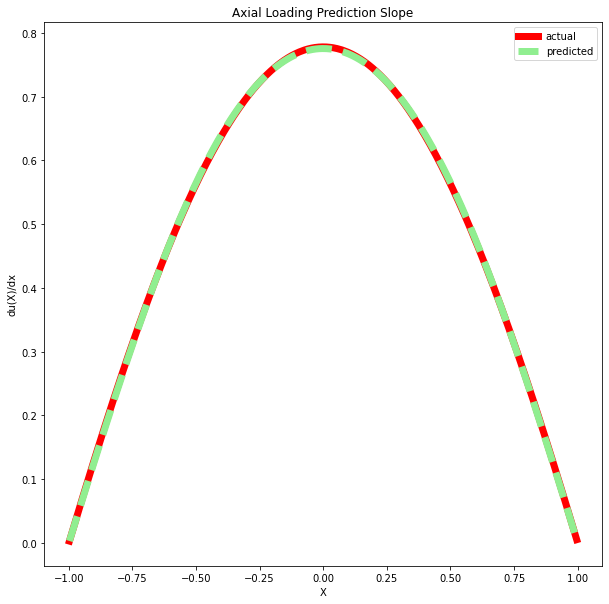

Training time: 15.054517269134521
Mean Absolute Error: 0.0004792338004335761
Mean Squared Error: 2.931206211087556e-07
Mean Absolute Percentage Error: 0.009296051226556301


In [ ]:
xmax = 1
xmin = -1

def q(X):
  return X

def actual_solution(X):
  return (68 + 105*X -40*X**3 + 3*X**5)/135

mymodel = AxialBar1D(xmax=xmax,
                     xmin = xmin,
                   q=q,
                   N=1000,
                   num_hidden_layers=1,
                   num_neurons_per_layer=10,
                   actual_solution=actual_solution,
                   epochs = 10000)

history = mymodel.train()
mymodel.plot_results()
# Get the training time:
training_time = history['training_time']
mae = history['mae']
mse = history['mse']
mape = history['mape']
print(f'Training time: {training_time}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')

### Experiment 2:
* N = 1000
* epochs = 10000
* xmin = -1
* xmax = 1
* number of hidden layers = 2
* number of neurons per layer = 20

It 0: loss = 0.6588107347488403
It 50: loss = 0.03324899077415466
It 100: loss = 0.014691157266497612
It 150: loss = 0.006691902410238981
It 200: loss = 0.003710746532306075
It 250: loss = 0.0024409720208495855
It 300: loss = 0.0017633906099945307
It 350: loss = 0.001317475107498467
It 400: loss = 0.0013630405301228166
It 450: loss = 0.0009521448519080877
It 500: loss = 0.0007529858266934752
It 550: loss = 0.02350642718374729
It 600: loss = 0.0007307862397283316
It 650: loss = 0.000462780095404014
It 700: loss = 0.00034026900539174676
It 750: loss = 0.00023291847901418805
It 800: loss = 0.0070489514619112015
It 850: loss = 0.0001665167073952034
It 900: loss = 8.184432954294607e-05
It 950: loss = 3.530322646838613e-05
It 1000: loss = 1.3885348380426876e-05
It 1050: loss = 6.378348189173266e-06
It 1100: loss = 4.311380507715512e-06
It 1150: loss = 0.0006642995867878199
It 1200: loss = 0.00014416579506359994
It 1250: loss = 9.21288210520288e-06
It 1300: loss = 6.909427611390129e-06
It 135

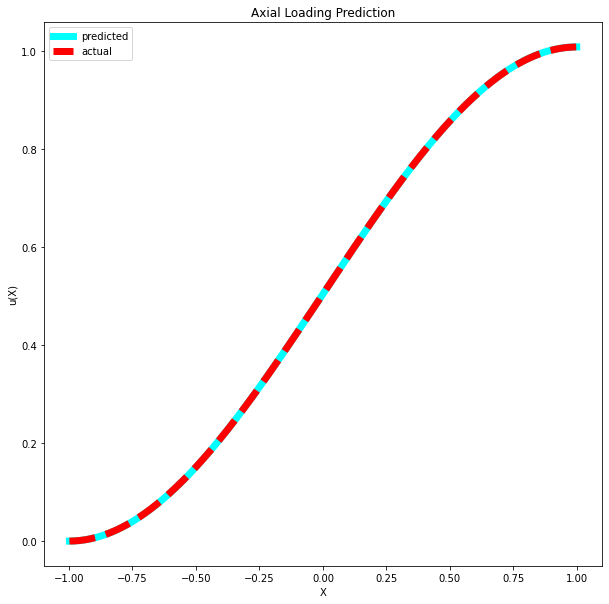

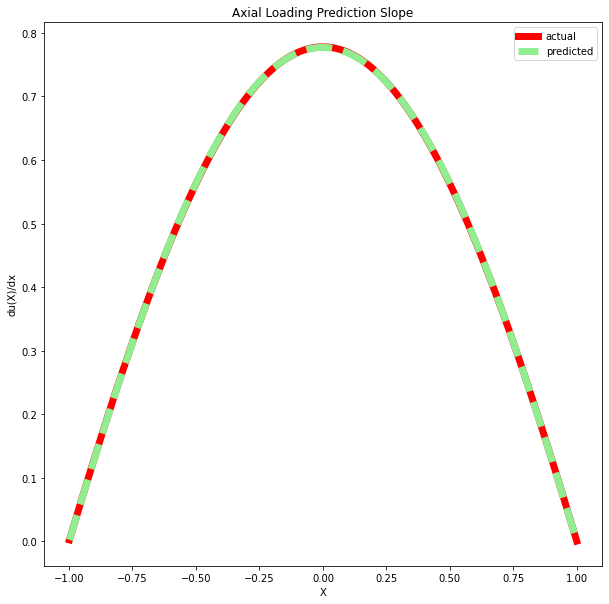

Training time: 31.107340812683105
Mean Absolute Error: 0.00011125655873911455
Mean Squared Error: 1.657716097724915e-08
Mean Absolute Percentage Error: 0.00379567570053041


In [ ]:
xmax = 1
xmin = -1

def q(X):
  return X

def actual_solution(X):
  return (68 + 105*X -40*X**3 + 3*X**5)/135

mymodel2 = AxialBar1D(xmax=xmax,
                     xmin = xmin,
                   q=q,
                   N=1000,
                   num_hidden_layers=2,
                   num_neurons_per_layer=20,
                   actual_solution=actual_solution,
                   epochs = 10000)

history2 = mymodel2.train()
mymodel2.plot_results()
# Get the training time:
training_time2 = history2['training_time']
mae2 = history2['mae']
mse2 = history2['mse']
mape2 = history2['mape']
print(f'Training time: {training_time2}')
print(f'Mean Absolute Error: {mae2}')
print(f'Mean Squared Error: {mse2}')
print(f'Mean Absolute Percentage Error: {mape2}')

### Experiment 3:

* N = 1000
* epochs = 10000
* xmin = -1
* xmax = 1
* number of hidden layers = 3
* number of neurons per layer = 20

It 0: loss = 0.35844865441322327
It 50: loss = 0.01541675254702568
It 100: loss = 0.0043855346739292145
It 150: loss = 0.0018676912877708673
It 200: loss = 0.0016687553143128753
It 250: loss = 0.0012946377974003553
It 300: loss = 0.001076565939001739
It 350: loss = 0.0007528963615186512
It 400: loss = 0.001115982187911868
It 450: loss = 0.0008339202031493187
It 500: loss = 0.0006295369821600616
It 550: loss = 0.00048413011245429516
It 600: loss = 0.03304910659790039
It 650: loss = 0.000693931186106056
It 700: loss = 0.0004711691290140152
It 750: loss = 0.00033747032284736633
It 800: loss = 0.0002419257361907512
It 850: loss = 0.00017161948198918253
It 900: loss = 0.00011993398948106915
It 950: loss = 8.242472540587187e-05
It 1000: loss = 0.0024208007380366325
It 1050: loss = 8.189281652448699e-05
It 1100: loss = 3.7033638363936916e-05
It 1150: loss = 1.8154109056922607e-05
It 1200: loss = 9.537746336718556e-06
It 1250: loss = 5.613604571408359e-06
It 1300: loss = 3.8089065128588118e-06

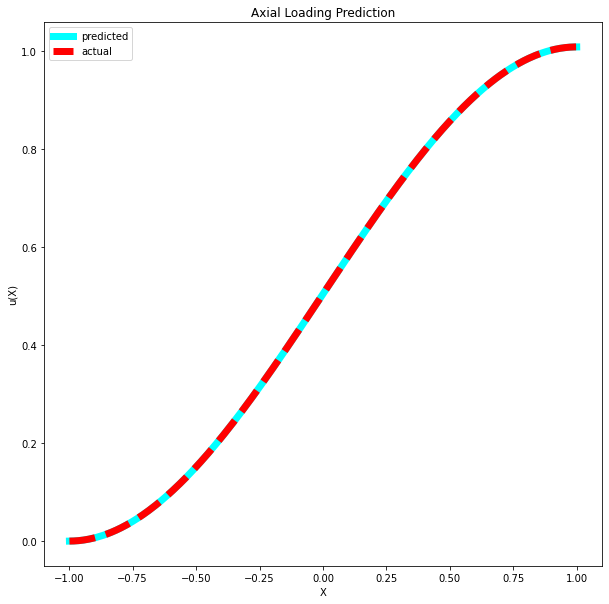

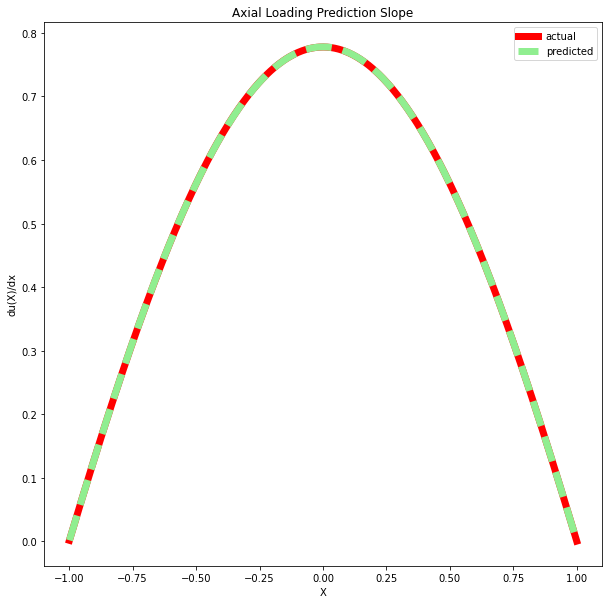

Training time: 46.011903524398804
Mean Absolute Error: 2.2272017304203473e-05
Mean Squared Error: 6.520610718041553e-10
Mean Absolute Percentage Error: 0.0005867318832315505


In [ ]:
xmax = 1
xmin = -1

def q(X):
  return X

def actual_solution(X):
  return (68 + 105*X -40*X**3 + 3*X**5)/135

mymodel3 = AxialBar1D(xmax=xmax,
                     xmin = xmin,
                   q=q,
                   N=1000,
                   num_hidden_layers=3,
                   num_neurons_per_layer=20,
                   actual_solution=actual_solution,
                   epochs = 10000)

history3 = mymodel3.train()
mymodel3.plot_results()
# Get the training time:
training_time3 = history3['training_time']
mae3 = history3['mae']
mse3 = history3['mse']
mape3 = history3['mape']
print(f'Training time: {training_time3}')
print(f'Mean Absolute Error: {mae3}')
print(f'Mean Squared Error: {mse3}')
print(f'Mean Absolute Percentage Error: {mape3}')

Experiment 4:

* N = 10000
* epochs = 10000
* xmin = -1
* xmax = 1
* number of hidden layers = 3
* number of neurons per layer = 20

It 0: loss = 0.23233121633529663
It 50: loss = 0.006508347578346729
It 100: loss = 0.0025610208977013826
It 150: loss = 0.005818705540150404
It 200: loss = 0.0015856127720326185
It 250: loss = 0.0011337536852806807
It 300: loss = 0.0022489232942461967
It 350: loss = 0.0010638149688020349
It 400: loss = 0.0007960603106766939
It 450: loss = 0.005680162459611893
It 500: loss = 0.0012209456181153655
It 550: loss = 0.0008415836491622031
It 600: loss = 0.0006511567044071853
It 650: loss = 0.000510656216647476
It 700: loss = 0.001764695392921567
It 750: loss = 0.0012313744518905878
It 800: loss = 0.0006526451907120645
It 850: loss = 0.0004940168000757694
It 900: loss = 0.00037726975278928876
It 950: loss = 0.00028571521397680044
It 1000: loss = 0.00021207726967986673
It 1050: loss = 0.048930030316114426
It 1100: loss = 0.00047124872799031436
It 1150: loss = 0.00017393275629729033
It 1200: loss = 6.983212369959801e-05
It 1250: loss = 2.6139847250306047e-05
It 1300: loss = 1.2482174497563392e-0

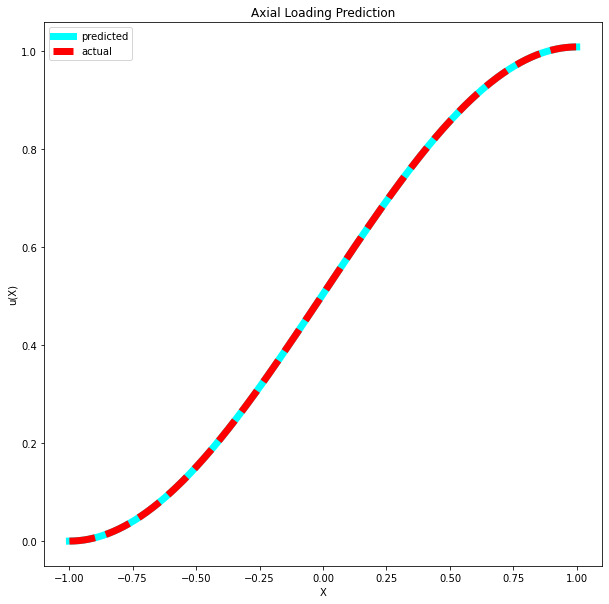

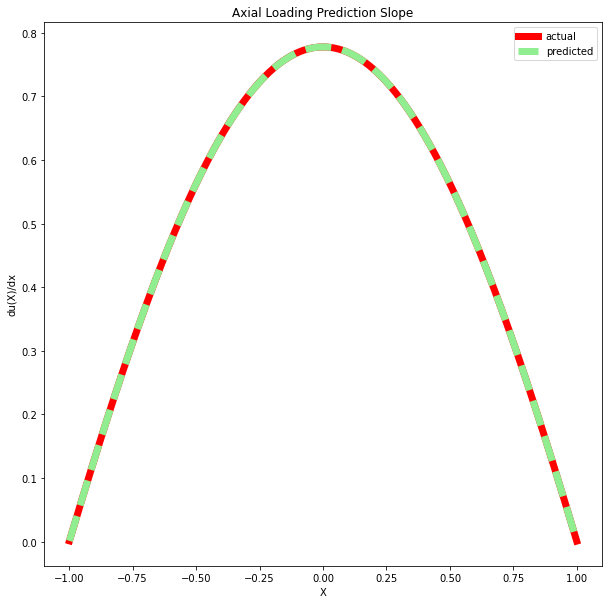

Training time: 42.87947750091553
Mean Absolute Error: 1.6630865502520464e-05
Mean Squared Error: 3.9094083525981205e-10
Mean Absolute Percentage Error: 0.0015039547579362988


In [ ]:
xmax = 1
xmin = -1

def q(X):
  return X

def actual_solution(X):
  return (68 + 105*X -40*X**3 + 3*X**5)/135

mymodel4 = AxialBar1D(xmax=xmax,
                     xmin = xmin,
                   q=q,
                   N=1000,
                   num_hidden_layers=3,
                   num_neurons_per_layer=20,
                   actual_solution=actual_solution,
                   epochs = 10000)

history4 = mymodel4.train()
mymodel4.plot_results()
# Get the training time:
training_time4 = history4['training_time']
mae4 = history4['mae']
mse4 = history4['mse']
mape4 = history4['mape']
print(f'Training time: {training_time4}')
print(f'Mean Absolute Error: {mae4}')
print(f'Mean Squared Error: {mse4}')
print(f'Mean Absolute Percentage Error: {mape4}')